In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from sparse_causal_model_learner_rl.config import Config
from keychest.features_xy import dict_to_arr, arr_to_dict, obs_features_handcoded
from causal_util import load_env

In [2]:
load_config_files(['../keychest/config/5x5_1f1c1k.gin', '../sparse_causal_model_learner_rl/configs/rec_nonlin_gnn_gumbel_siamese_l2.gin'])

['5x5_1f1c1k', 'rec_nonlin_gnn_gumbel_siamese_l2']

In [3]:
import ray
ray.init(address='10.90.38.7:6379', ignore_reinit_error=True)

2021-01-30 20:23:11,151	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2021-01-29_10-33-31_725376_19160',
 'metrics_export_port': 57367,
 'node_id': 'f237fb11fb3bc81e67f20ea7d86350e858dd333a'}

In [4]:
learner = CausalModelLearnerRL(Config())

2021-01-30 20:23:11,251	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 974a87a2-6330-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [5]:
learner.collect_steps()

In [6]:
ctx = learner._context

In [27]:
from keychest.features_xy import dict_to_arr, arr_to_dict, obs_features_handcoded

keys = sorted(obs_features_handcoded(learner.env.engine).keys())
keys_add = learner.additional_feature_keys


In [40]:
ox_norm = ctx['obs_x']
ox = learner.normalizers['obs'].unnormalize(ox_norm)

ax = ctx['action_x']
add_features_y = torch.cat([ctx[k] for k in keys_add], dim=1)

In [93]:
keys, keys_add

(['button__x',
  'button__y',
  'chest__00__x',
  'chest__00__y',
  'food__00__x',
  'food__00__y',
  'health',
  'key__00__x',
  'key__00__y',
  'keys',
  'lamp_off__x',
  'lamp_off__y',
  'lamp_on__x',
  'lamp_on__y',
  'lamp_status',
  'player__x',
  'player__y'],
 ['rew_y', 'done_y'])

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

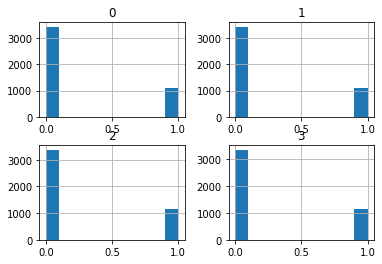

In [33]:
pd.DataFrame(ax.numpy()).hist()

array([[<AxesSubplot:title={'center':'button__x'}>,
        <AxesSubplot:title={'center':'button__y'}>,
        <AxesSubplot:title={'center':'chest__00__x'}>,
        <AxesSubplot:title={'center':'chest__00__y'}>],
       [<AxesSubplot:title={'center':'food__00__x'}>,
        <AxesSubplot:title={'center':'food__00__y'}>,
        <AxesSubplot:title={'center':'health'}>,
        <AxesSubplot:title={'center':'key__00__x'}>],
       [<AxesSubplot:title={'center':'key__00__y'}>,
        <AxesSubplot:title={'center':'keys'}>,
        <AxesSubplot:title={'center':'lamp_off__x'}>,
        <AxesSubplot:title={'center':'lamp_off__y'}>],
       [<AxesSubplot:title={'center':'lamp_on__x'}>,
        <AxesSubplot:title={'center':'lamp_on__y'}>,
        <AxesSubplot:title={'center':'lamp_status'}>,
        <AxesSubplot:title={'center':'player__x'}>],
       [<AxesSubplot:title={'center':'player__y'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

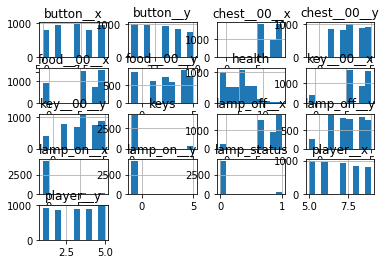

In [30]:
pd.DataFrame(ox.numpy(), columns=keys).hist()

array([[<AxesSubplot:title={'center':'rew_y'}>,
        <AxesSubplot:title={'center':'done_y'}>]], dtype=object)

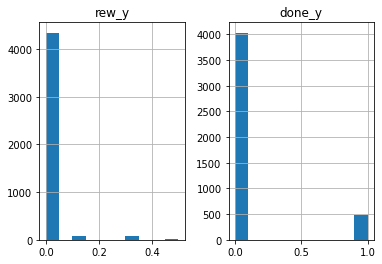

In [19]:
pd.DataFrame(add_features_y.numpy(), columns=learner.additional_feature_keys).hist()

In [94]:
def predict_done(f):
    d = arr_to_dict(arr=f, keys=keys)
    d = {x: int(round(y)) for x, y in d.items()}

    done = d['health'] <= 1
    if (d['player__x'], d['player__y']) == (d['food__00__x'], d['food__00__y']):
        done = False
    return done

In [95]:
dones_pred = np.array([predict_done(x.numpy()) for x in ox])
dones_true = add_features_y[:, keys_add.index('done_y')].numpy()

In [96]:
np.mean(dones_pred - dones_true)

0.0

In [88]:
def predict_rew(f):
    d = arr_to_dict(arr=f, keys=keys)
    d = {x: int(round(y)) for x, y in d.items()}
    r = 0.0
    r += learner.env.reward_dict['step']
    
    if d['player__x'] == d['food__00__x'] and d['player__y'] == d['food__00__y']:
        r += learner.env.reward_dict['food_collected']
        
    if d['player__x'] == d['key__00__x'] and d['player__y'] == d['key__00__y']:
        r += learner.env.reward_dict['key_collected']
        
    if d['player__x'] == d['chest__00__x'] and d['player__y'] == d['chest__00__y'] and d['keys'] > 0:
        r += learner.env.reward_dict['chest_opened']    
    return r

In [90]:
rew_pred = np.array([predict_rew(x.numpy()) for x in ox])
rew_true = add_features_y[:, keys_add.index('rew_y')].numpy()

In [92]:
np.max(np.abs(rew_pred - rew_true))

1.1920928966180355e-08